In [2]:
%matplotlib notebook
DEFAULT_FIGSIZE = (12, 8)

import os
import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia.record import Record, load_file
from antlia.dtype import load_converted_record
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint
from antlia import trial2

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

In [496]:
with open('../config.p', 'rb') as f:
        bicycle_calibration = pickle.load(f)

bicycle_record_files = [
    '2018-04-23_12-30-38.csv',
    '2018-04-23_13-13-36.csv',
    '2018-04-23_14-22-58.csv',
    '2018-04-23_15-27-48.csv',
    '2018-04-23_16-32-27.csv',
    '2018-04-23_17-14-00.csv',
    '2018-04-25_09-27-24.csv',
    '2018-04-25_10-20-28.csv',
    '2018-04-25_11-34-04.csv',
    '2018-04-25_12-41-48.csv',
    '2018-04-25_14-14-57.csv',
    '2018-04-25_14-49-39.csv',
    '2018-04-25_16-15-57.csv',
    '2018-04-25_17-23-04.csv',
    '2018-04-26_11-19-31.csv',
    '2018-04-26_14-50-53.csv',
    '2018-04-27_14-59-52.csv'
]

lidar_record_files = [
    '2018-04-23-12-17-37_0.pkl.gz',
    '2018-04-23-13-01-00_0.pkl.gz',
    '2018-04-23-14-10-33_0.pkl.gz',
    '2018-04-23-15-15-14_0.pkl.gz',
    '2018-04-23-16-19-35_0.pkl.gz',
    '2018-04-23-17-01-24_0.pkl.gz',
    '2018-04-25-09-15-00_0.pkl.gz',
    '2018-04-25-10-07-31_0.pkl.gz',
    '2018-04-25-11-21-29_0.pkl.gz',
    '2018-04-25-12-29-06_0.pkl.gz',
    '2018-04-25-14-02-15_0.pkl.gz',
    '2018-04-25-14-36-55_0.pkl.gz',
    '2018-04-25-16-03-24_0.pkl.gz',
    '2018-04-25-17-10-07_0.pkl.gz',
    '2018-04-26-11-07-38_0.pkl.gz',
    '2018-04-26-14-38-03_0.pkl.gz',
    '2018-04-27-14-47-07_0.pkl.gz',
    '2018-04-27-15-39-56_0.pkl.gz'
]

records = []
data_dir = '../../data/comfort'
i = 0
for file1, file2 in zip(bicycle_record_files, lidar_record_files):
    r1 = load_file(os.path.join(data_dir, file1), bicycle_calibration['convbike'])
    r2 = load_converted_record(os.path.join(data_dir, file2))
    r = Record(r2, r1)
    records.append(r)
    print('loaded record from files: {}, {}'.format(file1, file2))
    i += 1
    if i >= 8:
    #if i >= 0:
        break

loaded record from files: 2018-04-23_12-30-38.csv, 2018-04-23-12-17-37_0.pkl.gz
loaded record from files: 2018-04-23_13-13-36.csv, 2018-04-23-13-01-00_0.pkl.gz
loaded record from files: 2018-04-23_14-22-58.csv, 2018-04-23-14-10-33_0.pkl.gz
loaded record from files: 2018-04-23_15-27-48.csv, 2018-04-23-15-15-14_0.pkl.gz
loaded record from files: 2018-04-23_16-32-27.csv, 2018-04-23-16-19-35_0.pkl.gz
loaded record from files: 2018-04-23_17-14-00.csv, 2018-04-23-17-01-24_0.pkl.gz
loaded record from files: 2018-04-25_09-27-24.csv, 2018-04-25-09-15-00_0.pkl.gz
loaded record from files: 2018-04-25_10-20-28.csv, 2018-04-25-10-07-31_0.pkl.gz


In [497]:
# notes on missing syncs and repeated trials
missing_sync = [
   [680], None, None, None, None,
   None, None, None, None, None,
   None, None, None, None, None,
   None, None
]

trial_mask = [
   None, None, 0, None, None,
   0, None, None, 9, None,
   None, 11, 8, 9, None,
   None, None
]

#assert len(missing_sync) == len(records)

for i, (r, ms, tm) in enumerate(zip(records, missing_sync, trial_mask)):
    print('calculating trials for cyclist', i)
    
    try:
        r.sync()
        r._calculate_trials2(missing_sync=ms, trial_mask=tm)
    except (AssertionError, ValueError) as e:
        print('unable to calculate trials for cyclist', i)
        print(e)

calculating trials for cyclist 0
calculating trials for cyclist 1


../antlia/trial2.py:1148: UserWarning: Unable to detect cyclist exiting or braking for event ending at t = 689.011 seconds
  self.event = Event(


calculating trials for cyclist 2
calculating trials for cyclist 3
calculating trials for cyclist 4
calculating trials for cyclist 5
calculating trials for cyclist 6
calculating trials for cyclist 7


In [498]:
from antlia import kalman

# generate Kalman matrices
f, h, F, H = kalman.generate_fhFH(
    constant_velocity=True,
    wheelbase=0.6)

In [320]:
T = 1/125 # bicycle sample rate
q0 = 1
q1 = 0.01
Q = 1*np.diag([
    q0*T**3/6, # [m] x-position
    q0*T**3/6, # [m] y-position
    q1*T**2/2, # [rad/s] yaw angle
    q0*T**2/2, # [m/s] velocity 
    q1*T, # [rad/s] yaw rate
    q0*T, # [m/s^2] acceleration
])

P0 = np.diag([
    0.1,
    0.1,
    0.01,
    1,
    0.1,
    0.2
])

In [345]:
braking_df = pd.read_pickle('trial2_braking_ttc.p.gz')

In [351]:
braking_df[(braking_df['rider id'] == 0) & (braking_df['trial id'] == 0)]['braking starttime'].values[0]

128.377805

In [ ]:
event 

rider 2 trial 0
x0: [ 28.76500853   2.92401687   3.14159265   2.177408     0.           0.        ]


<IPython.core.display.Javascript object>


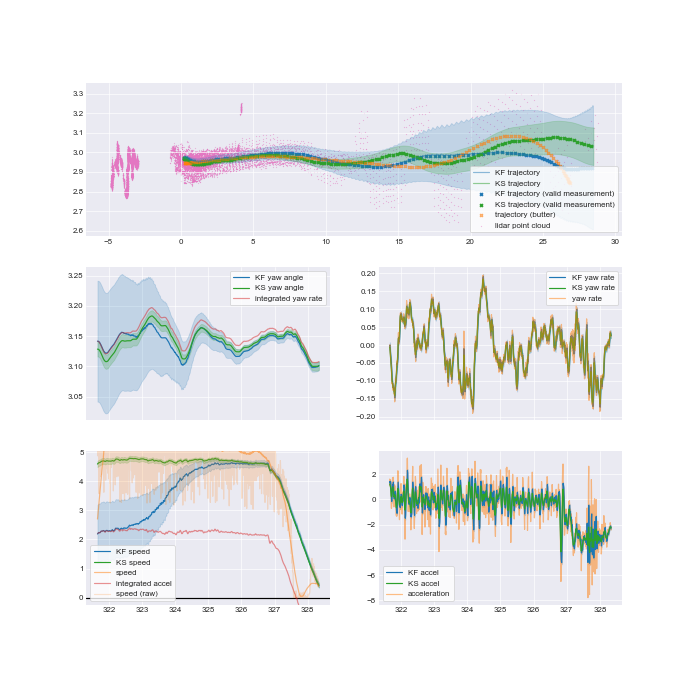

rider 2 trial 1
x0: [ 29.7460024    2.81096147   3.14159265   3.11291143   0.           0.        ]


<IPython.core.display.Javascript object>


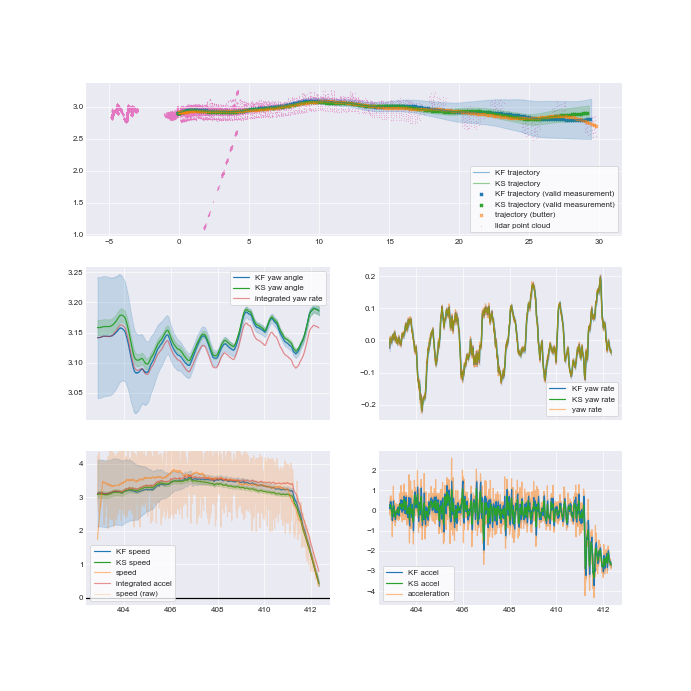

rider 2 trial 2
x0: [ 29.76448413   2.9378915    3.14159265   4.32366378   0.           0.        ]


<IPython.core.display.Javascript object>


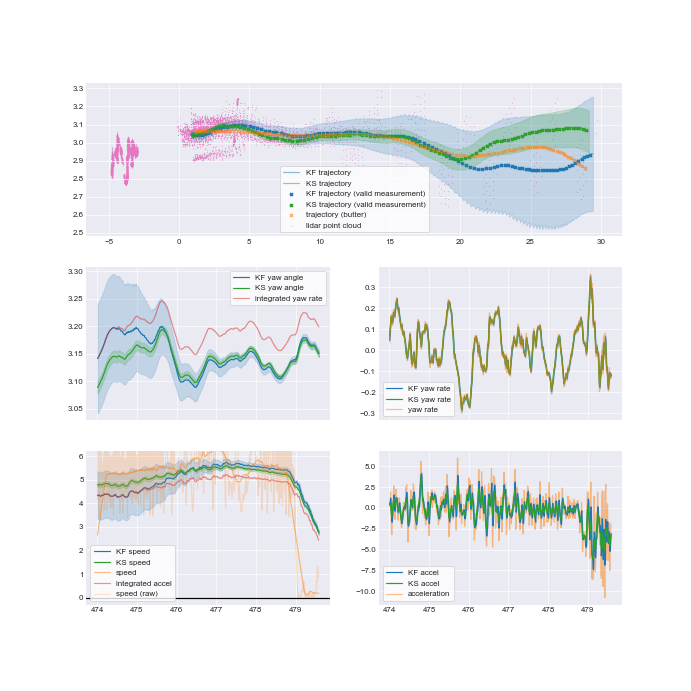

rider 2 trial 3
x0: [ 29.80038618   2.85207866   3.14159265   4.75363616   0.           0.        ]


<IPython.core.display.Javascript object>


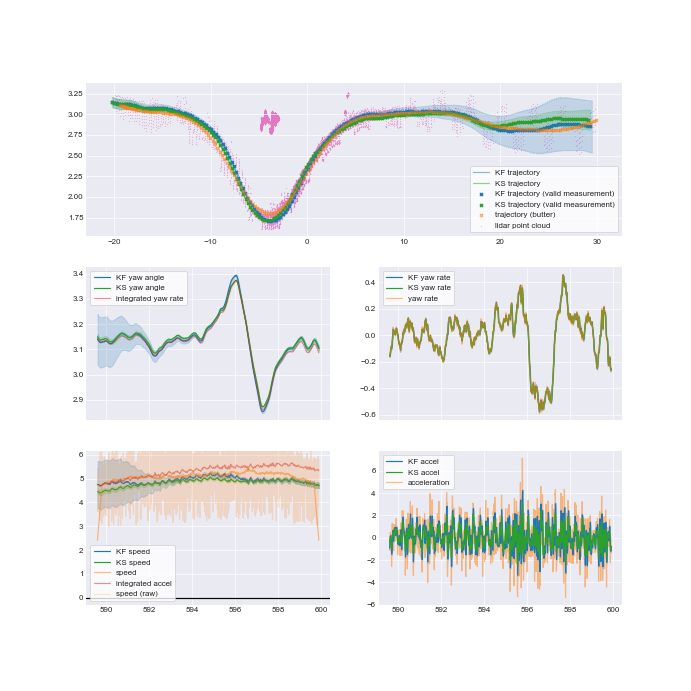

rider 2 trial 4
x0: [ 32.2158543    3.04896228   3.14159265   5.98944511   0.           0.        ]


<IPython.core.display.Javascript object>


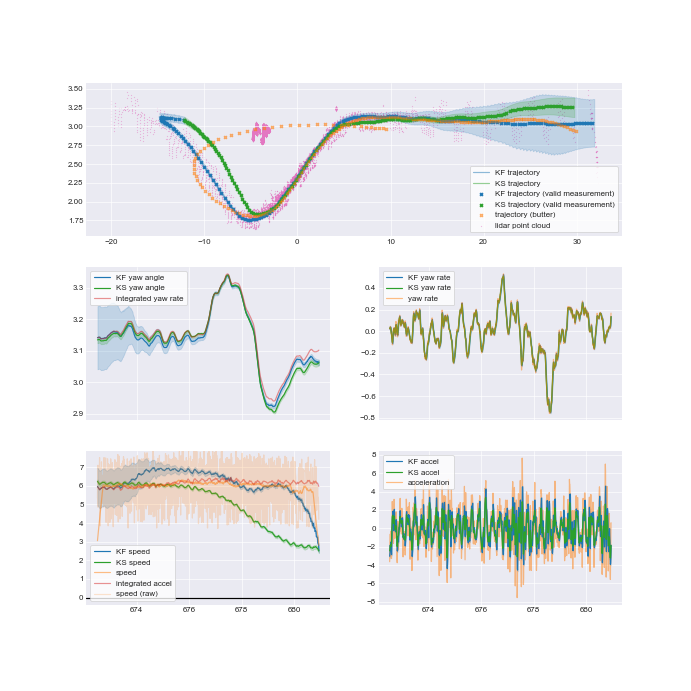

rider 2 trial 5
x0: [ 29.89532764   3.02375522   3.14159265   2.64026533   0.           0.        ]


<IPython.core.display.Javascript object>


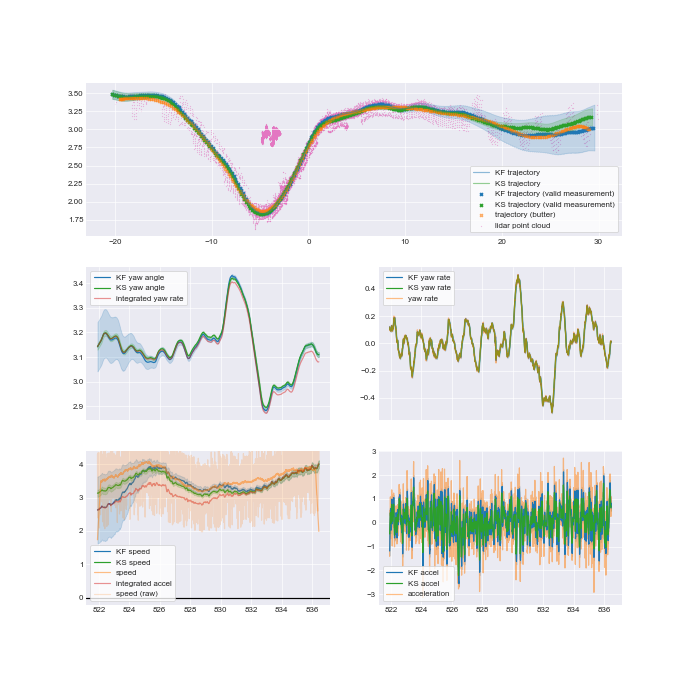

rider 2 trial 6
x0: [ 29.02711083   3.0047184    3.14159265   5.76752384   0.           0.        ]


<IPython.core.display.Javascript object>


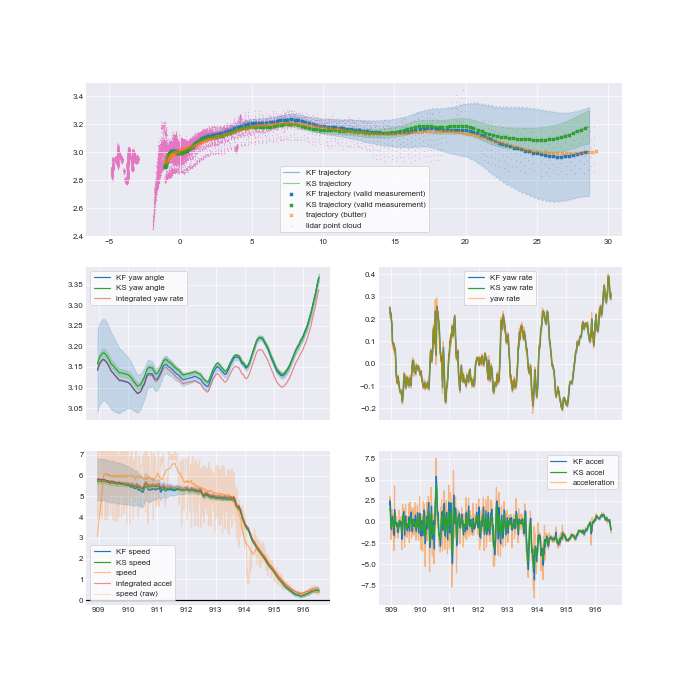

rider 2 trial 7
x0: [ 28.98962627   3.21536669   3.14159265   2.53504896   0.           0.        ]


<IPython.core.display.Javascript object>


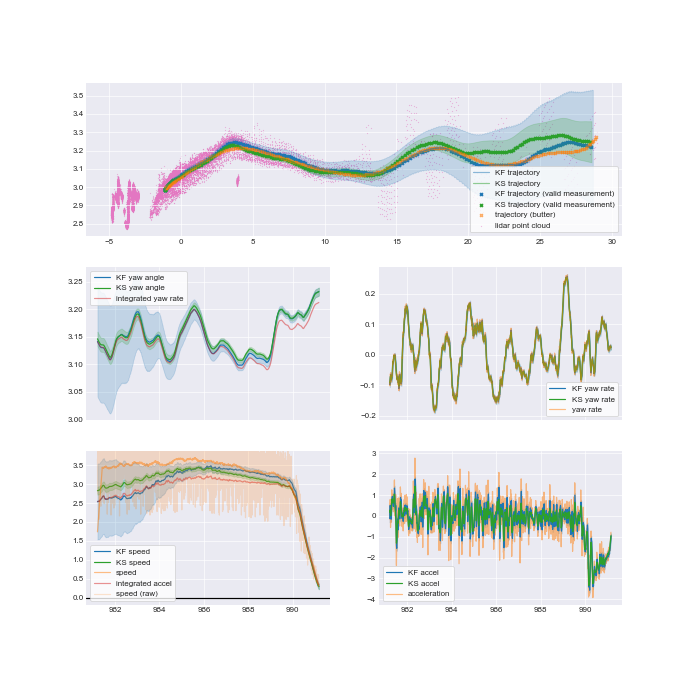

rider 2 trial 8
x0: [ 29.78791948   3.29228818   3.14159265   4.87783426   0.           0.        ]


<IPython.core.display.Javascript object>


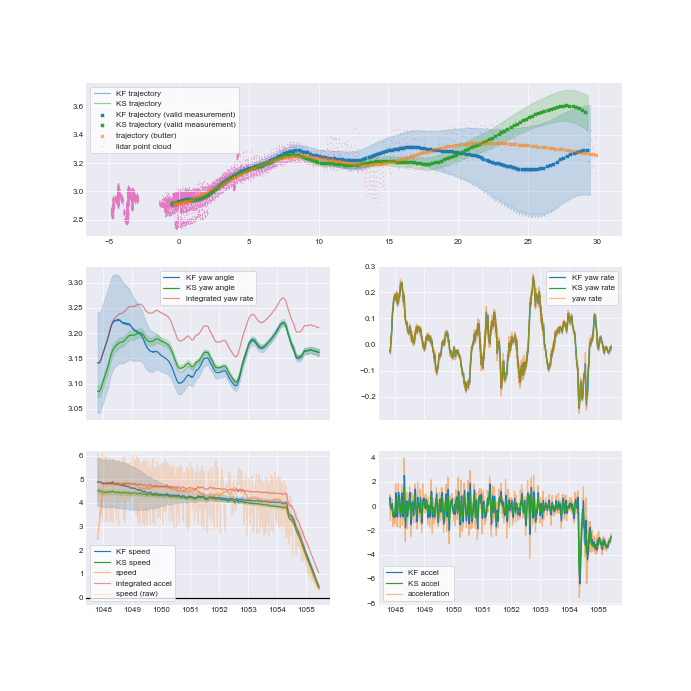

rider 2 trial 9
x0: [ 28.41118653   3.17466332   3.14159265   3.57773278   0.           0.        ]


<IPython.core.display.Javascript object>


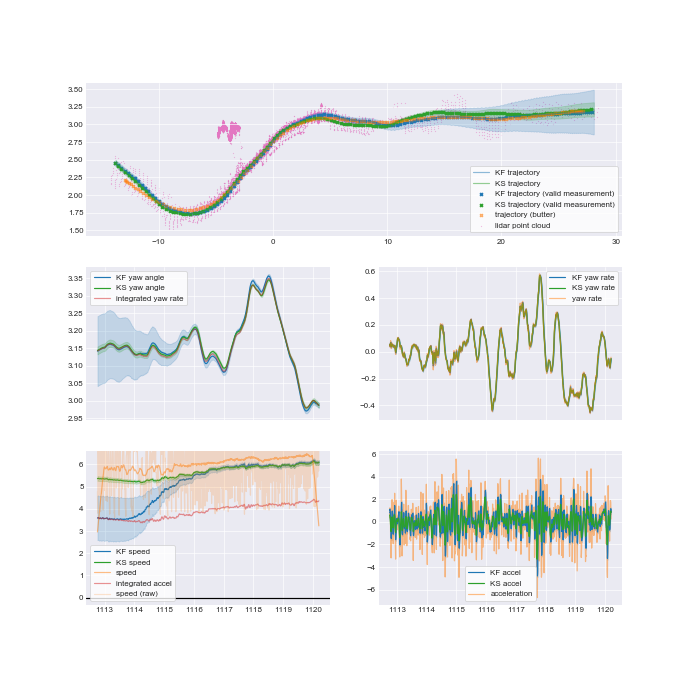

rider 2 trial 10
x0: [ 29.88510136   2.99004924   3.14159265   4.51027018   0.           0.        ]


<IPython.core.display.Javascript object>


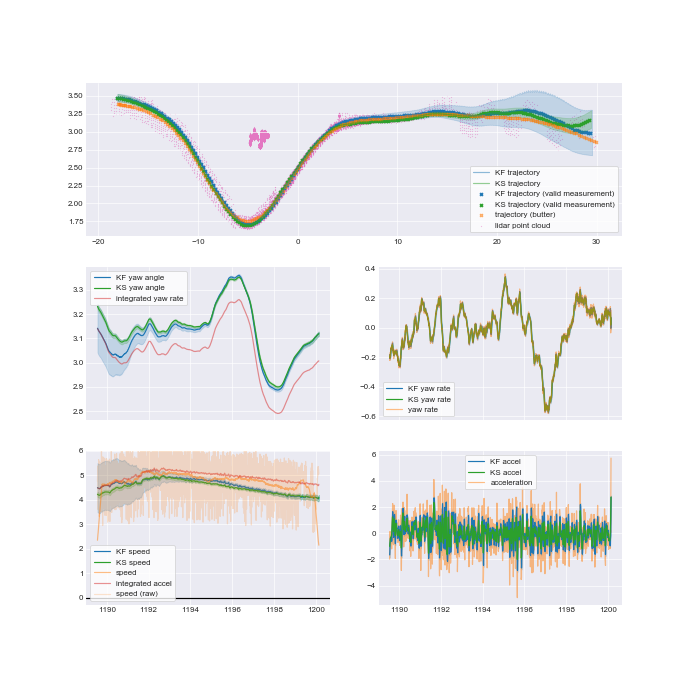

rider 2 trial 11
x0: [ 29.12755251   3.21932772   3.14159265   2.58500065   0.           0.        ]


<IPython.core.display.Javascript object>


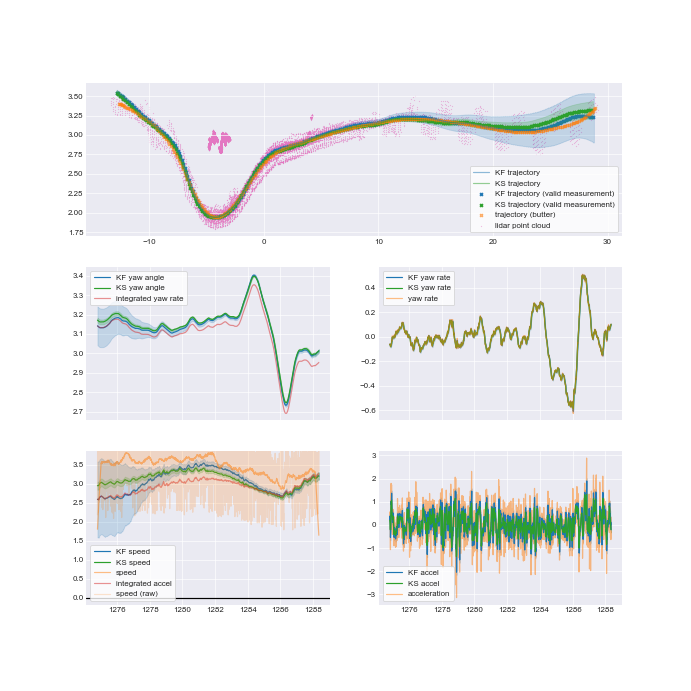

rider 2 trial 12
x0: [ 29.14022333   2.9497649    3.14159265   3.21125817   0.           0.        ]


<IPython.core.display.Javascript object>


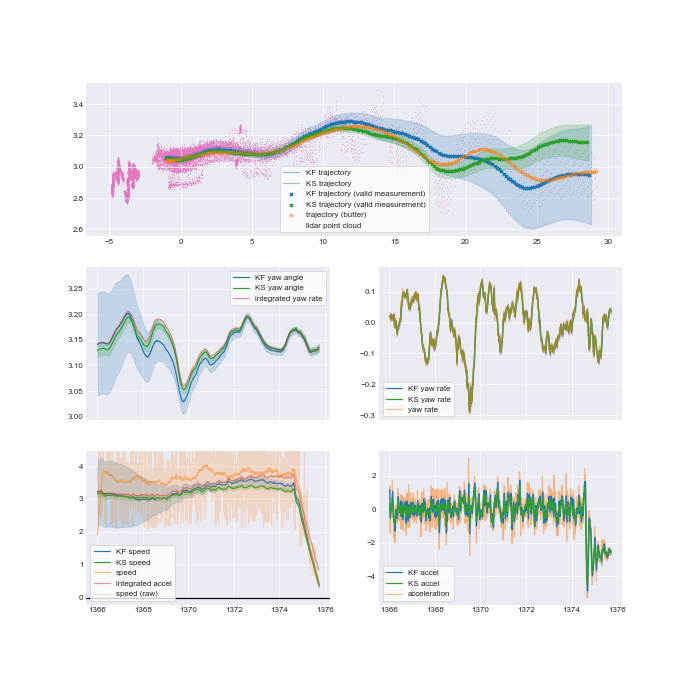

rider 2 trial 13
x0: [ 29.34815161   3.24194904   3.14159265   4.73143584   0.           0.        ]


<IPython.core.display.Javascript object>


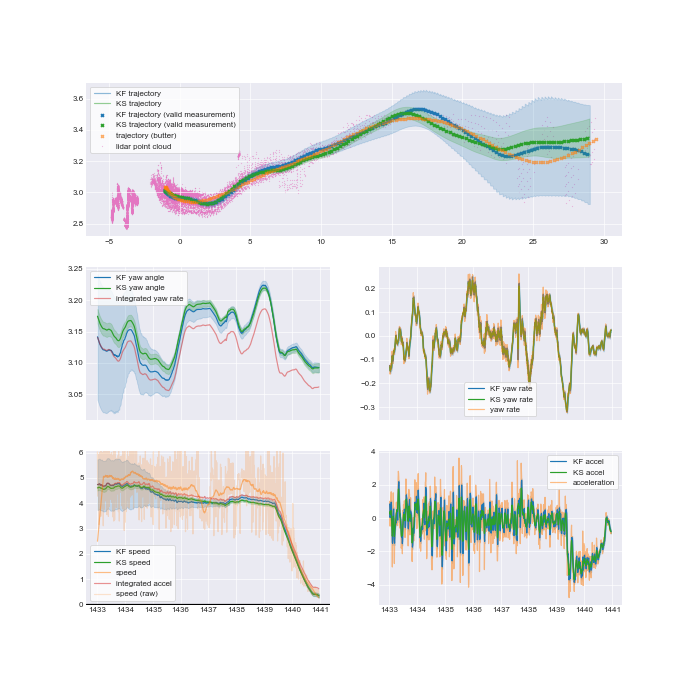

rider 2 trial 14
x0: [ 29.36693725   3.16651818   3.14159265   5.62778124   0.           0.        ]


<IPython.core.display.Javascript object>


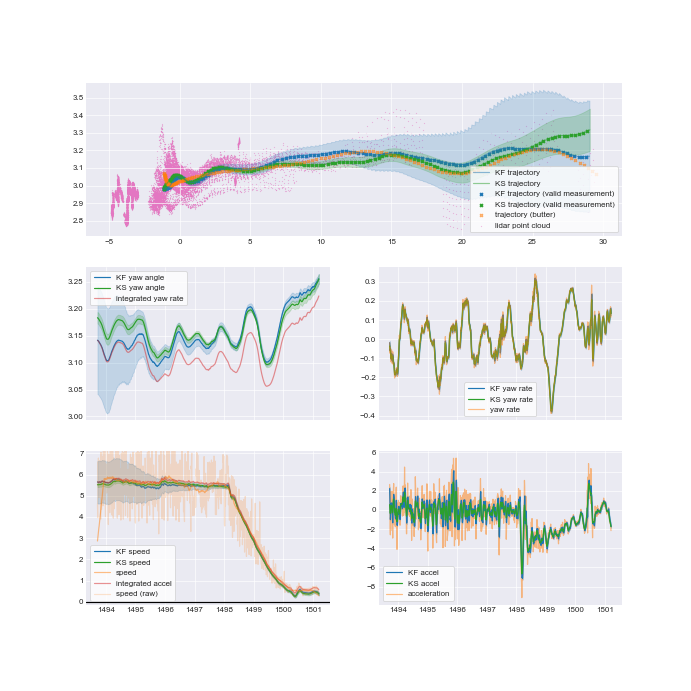

rider 2 trial 15
x0: [ 29.00136808   3.06735616   3.14159265   3.57849059   0.           0.        ]


<IPython.core.display.Javascript object>


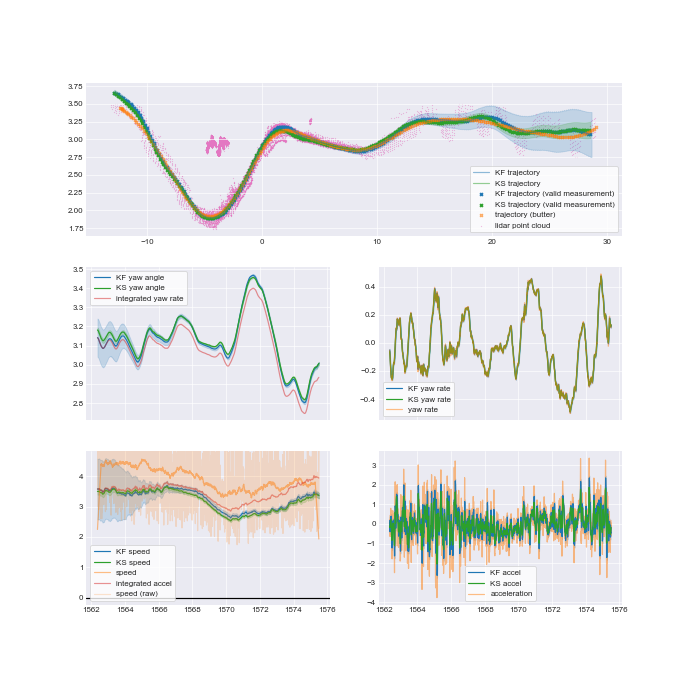

rider 2 trial 16
x0: [ 28.68379008   3.25670011   3.14159265   5.69093089   0.           0.        ]


<IPython.core.display.Javascript object>


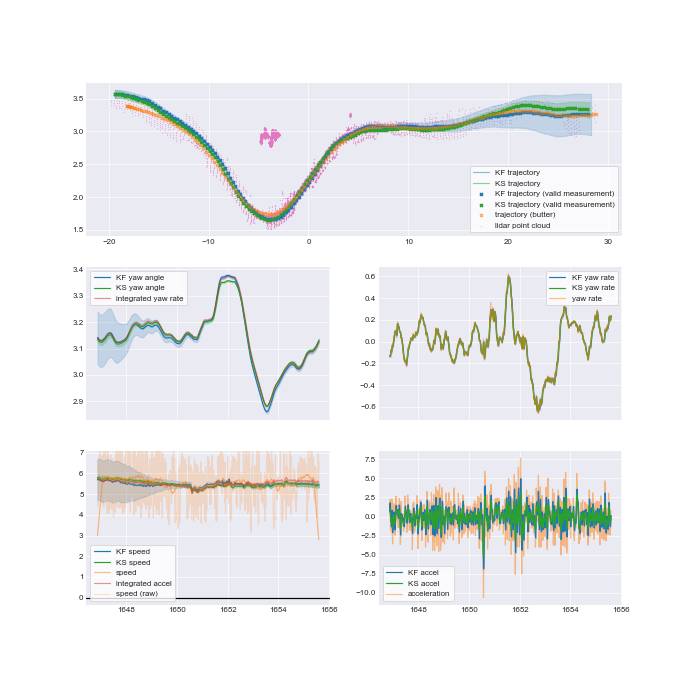

rider 2 trial 17
x0: [ 29.79839607   2.81760196   3.14159265   4.7782925    0.           0.        ]


<IPython.core.display.Javascript object>


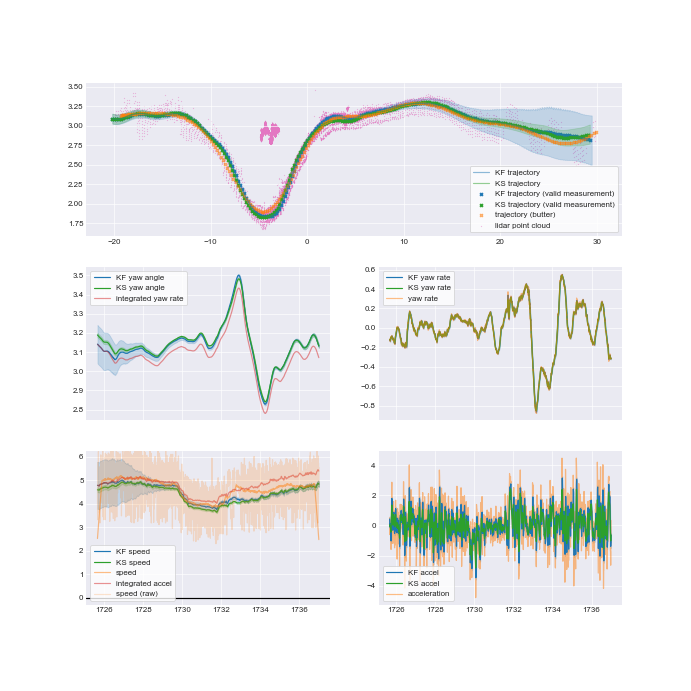

In [572]:
import scipy.stats

#tol = [1, 1, 0, 0]
tol = [0, 0, 0, 0]

error_set = {
    (1, 3),
    (1, 5),
    (1, 9),
    (1, 15),
    (1, 17),
    (2, 1),
    (2, 2),
    (2, 7),
    (3, 15),
    (3, 16),
    (3, 17),
    (4, 1),
    (4, 2),
    (4, 6),
    (4, 7),
    (4, 12),
    (7, 17),
}
error_set = {
    (1, 2),
    (1, 5),
    (1, 15),
}

linregress_kf = []
linregress_ks = []

plt.close('all')
for i, r in enumerate(records):
    if i != 2:
        continue
        
    R = kalman.generate_R(r)
    
    for j, tr in enumerate(r.trials):
        event = tr.event
        #if event.type.value != trial2.EventType.Braking.value:
        #    continue
        #    
        #if (i, j) not in error_set:
        #    continue
        
        z = kalman.generate_measurement(event)
        x0 = kalman.initial_state_estimate(z)
        x0[0] = event.x.max()
        a, b = event.x.max(axis=1)[[0, 20]]
        v = a - b
        if v > 3 and v < 7:
            x0[3] = v 
        assert x0[0] > 20, 'initial x: {:0.3f}'.format(x0[0])
        assert x0[1] > 2.5 and x0[1] < 3.5, 'initial y: {:0.3f}'.format(x0[1])
        assert x0[3] > 1, 'initial velocity: {:0.3f}'.format(x0[3])
        print('rider {} trial {}'.format(i, j))
        print('x0:', x0)
        
        KF = kalman.Kalman(F, H, Q, R, f, h)
        result = KF.estimate(x0, P0, z, tol)
        smooth = KF.smooth_estimate(result)
        
        fig, ax = kalman.plot_kalman_result(result, event, smooth, wheelbase=0.6,
                                            figsize=(12, 12))
        plt.show()
        
        #v_kf = result.state_estimate[:, 3].squeeze()
        #v_ks = smooth.state_estimate[:, 3].squeeze()
        #
        #df_ij = braking_df[(braking_df['rider id'] == i) &
        #                   (braking_df['trial id'] == j)]
        #
        #t = event.bicycle.time
        #t0 = df_ij['braking starttime'].values[0]
        #tf = df_ij['braking endtime'].values[0]
        #index = (t >= t0) & (t <= tf)
        #
        ## best-fit line metrics
        #linregress_kf.append(scipy.stats.linregress(
        #    t[index],
        #    v_kf[index]))
        #linregress_ks.append(scipy.stats.linregress(
        #    t[index],
        #    v_ks[index]))

In [364]:
df_kf = pd.DataFrame(linregress_kf,
                     columns=[
                         'linregress slope',
                         'linregress intercept',
                         'linregress r-value',
                         'linregress p-value',
                         'linregress stderr',
                     ])
df_ks = pd.DataFrame(linregress_ks,
                     columns=[
                         'linregress slope',
                         'linregress intercept',
                         'linregress r-value',
                         'linregress p-value',
                         'linregress stderr',
                     ])

In [371]:
slope = []
slope_kf = []
slope_ks = []

for (_, row), (_, row_kf), (_, row_ks) in zip(braking_df.iterrows(),
                                              df_kf.iterrows(),
                                              df_ks.iterrows()):
    a = row['linregress slope']
    b = row_kf['linregress slope']
    c = row_ks['linregress slope']
    
    # skip trial if wheel lockup occurs
    if row['lockup ranges']:
        print('skipping {}-{} due to wheel lockup'.format(
            int(row['rider id']), int(row['trial id'])))
        continue
        
    # skip trial if either fit value exceeds 4 m/s^2
    if abs(a) > 4 or abs(b) > 4 or abs(c) > 4:
        print('skipping {}-{} due to invalid deceleration'.format(
            int(row['rider id']), int(row['trial id'])))
        continue
    slope.append(a)
    slope_kf.append(b)
    slope_ks.append(c)
    
print('\nstats using kalman filter:')
print(scipy.stats.ttest_rel(slope, slope_kf))
print(scipy.stats.linregress(slope, slope_kf))
print('mean: ', np.mean(slope_kf))
    
print('\nstats using kalman smoother:')
print(scipy.stats.ttest_rel(slope, slope_ks))
print(scipy.stats.linregress(slope, slope_ks))
print('mean: ', np.mean(slope_ks))

print('\nmean(from measured): ', np.mean(slope))

skipping 1-5 due to invalid deceleration
skipping 2-0 due to wheel lockup
skipping 2-2 due to wheel lockup
skipping 4-1 due to invalid deceleration

stats using kalman filter:
Ttest_relResult(statistic=1.1028376230902326, pvalue=0.27410282979955575)
LinregressResult(slope=0.90755010021632032, intercept=-0.17397458497520391, rvalue=0.9580272659858079, pvalue=5.5258803233922315e-37, stderr=0.03368441880573874)
mean:  -1.58922365019

stats using kalman smoother:
Ttest_relResult(statistic=-0.47639047971251658, pvalue=0.63536959552947725)
LinregressResult(slope=0.8244311953069674, intercept=-0.25846734033889929, rvalue=0.94238172300863177, pvalue=1.2819044767984043e-32, stderr=0.036300976565419668)
mean:  -1.54409937125

mean(from measured):  -1.55941701166


In [381]:
slope = []
slope_kf = []
slope_ks = []

invalid_set = {
    (1, 3),
    (1, 5),
    (1, 9),
    (1, 15),
    (1, 17),
    (2, 1),
    (2, 2),
    (2, 7),
    (3, 15),
    (3, 16),
    (3, 17),
    (4, 1),
    (4, 2),
    (4, 6),
    (4, 7),
    (4, 12),
    (7, 17)
}
    
skipped = []
for (_, row), (_, row_kf), (_, row_ks) in zip(braking_df.iterrows(),
                                              df_kf.iterrows(),
                                              df_ks.iterrows()):
    a = row['linregress slope']
    b = row_kf['linregress slope']
    c = row_ks['linregress slope']
    
    i = int(row['rider id'])
    j = int(row['trial id'])
    
    # skip invalid trials
    if (i, j) in invalid_set:
        skipped.append('{}-{}'.format(i, j))
        continue
        
    slope.append(a)
    slope_kf.append(b)
    slope_ks.append(c)
    
print('skipping: {}'.format(', '.join(skipped)))

print('\nstats using kalman filter:')
print(scipy.stats.ttest_rel(slope, slope_kf))
print(scipy.stats.linregress(slope, slope_kf))
print('mean: ', np.mean(slope_kf))
    
print('\nstats using kalman smoother:')
print(scipy.stats.ttest_rel(slope, slope_ks))
print(scipy.stats.linregress(slope, slope_ks))
print('mean: ', np.mean(slope_ks))

print('\nmean(from measured): ', np.mean(slope))

skipping: 1-3, 1-5, 1-9, 1-15, 1-17, 2-1, 2-2, 2-7, 3-15, 3-16, 3-17, 4-1, 4-2, 4-6, 4-7, 4-12, 7-17

stats using kalman filter:
Ttest_relResult(statistic=5.2430817581494145, pvalue=2.805992169961336e-06)
LinregressResult(slope=1.0175515458178641, intercept=-0.063005359230778657, rvalue=0.98476883071055832, pvalue=3.4656802501645223e-41, stderr=0.024913918565687185)
mean:  -1.5873600947

stats using kalman smoother:
Ttest_relResult(statistic=2.1799448590265116, pvalue=0.033724338070094728)
LinregressResult(slope=0.91769629251235874, intercept=-0.17362211369339398, rvalue=0.96989415610722118, pvalue=1.42908060436185e-33, stderr=0.031953601252120448)
mean:  -1.54838754446

mean(from measured):  -1.49806144144
